In [31]:
import numpy as np
import pandas as pd
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle
from tqdm import tqdm

Mean degree: 9.995
Calculating best minimal value for power law fit
Estimated power law exponent: 2.82887146988854


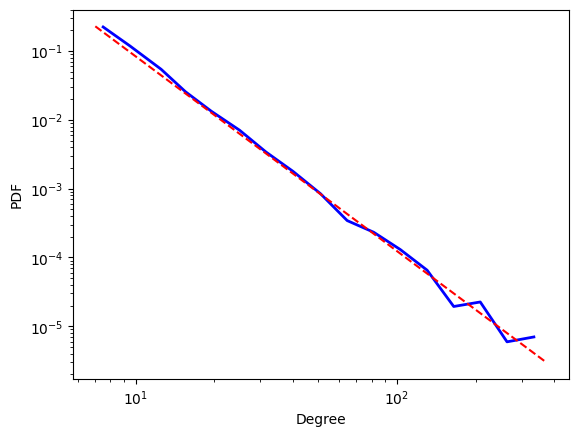

In [22]:
# Parameters for the scale-free network
alpha = 0.2  # Probability of adding a new node connected to an existing node (in-degree)
beta = 0.7 # Probability of adding an edge between two existing nodes
gamma = 0.1  # Probability of adding a new node connected to an existing node (out-degree)

# Generate the network
#g = nx.scale_free_graph(100_000, alpha=alpha, beta=beta, gamma=gamma)
#g = g.to_undirected()

g = nx.barabasi_albert_graph(10_000, 5)

# Get the in-degree distribution
degrees = [d for n, d in g.degree()]
print(f"Mean degree: {np.mean(degrees)}")

# Fit the degree distribution to a power law
fit = powerlaw.Fit(degrees, discrete=True)
print(f"Estimated power law exponent: {fit.power_law.alpha}")

# Plot the degree distribution
fig = fit.plot_pdf(color='b', linestyle='-', linewidth=2)
fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)
plt.xlabel('Degree')
plt.ylabel('PDF')
plt.show()


In [30]:
N = 10_000
f = 1/N
iterations = 1e6
n_cores = mp.cpu_count()

networks = [
    nx.barabasi_albert_graph(10_000, 5), 
    nx.barabasi_albert_graph(10_000, 1),
    nx.erdos_renyi_graph(10_000, 0.0007),
    nx.erdos_renyi_graph(10_000, 0.002),
    nx.scale_free_graph(10_000, 0.1, 0.1, 0.8).to_undirected(),
    nx.scale_free_graph(10_000, 0.35, 0.3, 0.35).to_undirected(),
    nx.scale_free_graph(10_000, 0.4, 0.1, 0.5).to_undirected(),
    nx.scale_free_graph(10_000, 0.2, 0.7, 0.1).to_undirected(),
]

labels = [
    "BA_5", 
    "BA_1", 
    "ER_0-0007", 
    "ER_0-002", 
    "SF_0-1_0-1_0-8", 
    "SF_0-35_0-3_0-35", 
    "SF_0-4_0-1_0-5", 
    "SF_0-2_0-7_0-1"
]

inputs = [(networks[i], labels[i], f, iterations) for i in range(len(networks))]

In [34]:
def dynamics(g, f, iterations):
    N = g.number_of_nodes()
    degree = [d for _, d in g.degree()]

    load = np.zeros(N)
    critical_load = np.array(degree)

    res = pd.DataFrame({
        "iteration": [],
        "S": [],
        "T": [],
        "G": [],
        "A": []
    })

    # Run the simulation
    for i in tqdm(range(int(iterations))):
        unstable_queue = []

        # Select a random node
        node = np.random.randint(N)
        
        # Update the load of the selected node
        load[node] += 1

        # Check if the node has become unstable
        if load[node] > critical_load[node]:
            unstable_queue.append(node)

        # Solve unstable queue
        S = []
        T = 1
        G = 0
        while len(unstable_queue) > 0:
            # Pick the first node in the queue
            node = unstable_queue.pop(0)
            S.append(node)

            # Get the neighbors of the node
            neighbors = list(g.neighbors(node))

            # Sample a fraction of the neighbors
            to_keep = np.random.rand(len(neighbors)) > f
            neighbors = [neighbors[i] for i in range(len(neighbors)) if to_keep[i]]
            G = G + len(neighbors)

            # Update the load of the neighbors
            load[neighbors] += 1

            # Update the state of the node
            load[node] = 0

            # Check if the neighbors have become unstable
            unstable_neighbors = [n for n in neighbors if load[n] > critical_load[n]]
            if len(unstable_neighbors) > 0:
                unstable_queue.extend(unstable_neighbors)
                unstable_queue = list(set(unstable_queue))
                T += 1

        A = list(set(S))

        if (len(A) > 0):
            res.loc[len(res)] = {
                "iteration": i,
                "S": len(S),
                "T": T,
                "G": G,
                "A": len(A)
            }    

    return res

def doParallel(g, label, f, iterations):
    res = dynamics(g, f, iterations)
    
    # Save the results
    res.to_csv(f"{label}.csv")
    # Save the network
    with open(f"{label}.gpickle", "wb", pickle.HIGHEST_PROTOCOL) as f:
        pickle.dump(g, f)

Values less than or equal to 0 in data. Throwing out 0 or negative values


Mean degree: 1.0012
Calculating best minimal value for power law fit
Estimated power law exponent: 6.712013652189742


 14%|█▍        | 14284/100000 [00:05<00:33, 2569.11it/s]


KeyboardInterrupt: 

In [49]:
with open("temp_data/ER_0-0007.csv", "rb") as f:
    res = pd.read_csv(f)

print(len(res))

154982


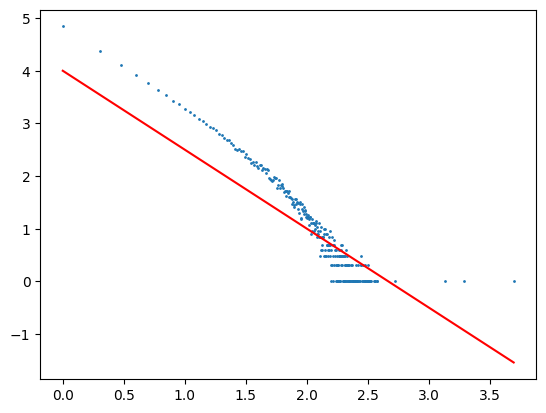

In [50]:
area = res.groupby("A", as_index=False).count()

x, y = np.log10(area["A"]), np.log10(area["iteration"])
plt.scatter(x, y, s=1)
plt.plot(x, -1.5*x+4, c='r')


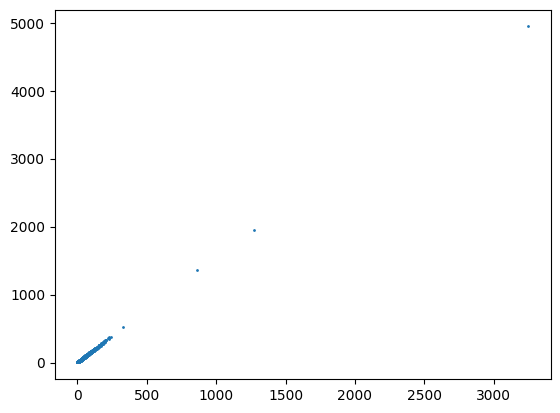

In [51]:
x, y = res["T"], res["A"]
plt.scatter(x, y, s=1)
#plt.plot(np.sort(x), np.sort(x)**1.5, c='r')